# Position-Switched Data Reduction

This notebook shows how to use `dysh` to calibrate an **OnOff** observation.
It retrieves and calibrates position-switch scans using `GBTFITSLoad.getps()`, which returns a `ScanBlock` object. These in turn can be averaged into a `Spectrum`. **OffOn** observations can be reduced the same way.

## Dysh commands

The following dysh commands are introduced (leaving out all the function arguments):

      filename = dysh_data()
      sdf = GBTFITSLoad()
      sdf.select()
      sb = sdf.getps()
      ta = sb.timeaverage()
      ta.baseline()
      ta.average()
      ta.plot()
      ta_plt.savefig()


## Loading Modules
We start by loading the modules we will use for the data reduction. 

For display purposes, we use the static (non-interactive) `matplotlib` backend in this tutorial. However, you can tell `matplotlib` to use the `ipympl` backend to enable interactive plots. This is only needed if working on `jupyter` lab or notebook.

In [1]:
# Set interactive plots in jupyter.
#%matplotlib ipympl

# These modules are required for the data reduction.
from dysh.fits.gbtfitsload import GBTFITSLoad
from astropy import units as u
from dysh.log import init_logging

# These modules are used for file I/O
from dysh.util.files import dysh_data
from pathlib import Path

## Setup
We start the dysh logging, so we get more information about what is happening.
This is only needed if working on a notebook.
If using the CLI through the ``dysh`` command, then logging is setup for you.

In [2]:
init_logging(2)

# also create a local "output" directory where temporary notebook files can be stored.
output_dir = Path.cwd() / "output"
output_dir.mkdir(exist_ok=True)

## Data Retrieval

Download the example SDFITS data, if necessary. The actual filename will depend on your dysh installation, it could be local, or it will need to be downloaded.

The [dysh_data](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.util.html#dysh.util.files.dysh_data)
function has a few mnemonics, to avoid having to remember long filenames.

In [3]:
filename = dysh_data(test="getps")

18:37:59.115 I Resolving test=getps -> AGBT05B_047_01/AGBT05B_047_01.raw.acs/


## Data Loading

Next, we use [GBTFITSLoad](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.fits.html#dysh.fits.gbtfitsload.GBTFITSLoad)
to load the data, and then its `summary` method to inspect its contents.

In [4]:
sdfits = GBTFITSLoad(filename)

In [5]:
sdfits.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
51,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,198.3431,18.6427
52,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,198.9306,18.7872
53,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,199.3305,18.3561
54,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,199.9157,18.4927
55,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,200.3042,18.0575
56,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,200.8906,18.1860
57,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,202.3275,17.3853
58,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,202.9192,17.4949


Here the **PROCSEQN** designates which scan is the "On" (1) and which the Off (2). If you like to see more columns, use the `add_columns` argument to `summary`, as we saw in the metadata notebook.

## Data Reduction

### Single Scan

Next we calibrate one scan of the position switched observations. We will start with scan 51, a single spectral window, polarization and feed.

If you don't want to calibrate, add, `calibrate=False`.

In [6]:
ps_scan_block = sdfits.getps(scan=51, ifnum=0, plnum=0, fdnum=0)

In [7]:
print(f"T_sys = {ps_scan_block[0].tsys.mean():.2f}")

T_sys = 19.36


#### Time Averaging

To time average the contents of a `ScanBlock` use its `timeaverage` method. Be aware that time averging will not check if the source is the same.

By default time averaging uses the following weights: 
$$
\frac{T^{2}_{sys}}{\Delta\nu\Delta t}
$$
with $T_{sys}$ the system temperature, $\Delta\nu$ the channel width and $\Delta t$ the integration time. In `dysh` these are set using `weights='tsys'` (the default).

In [8]:
ta = ps_scan_block.timeaverage(weights='tsys')

#### Plotting

Plot the data and use different units for the spectral axis. Without any arguments it will auto-scale.

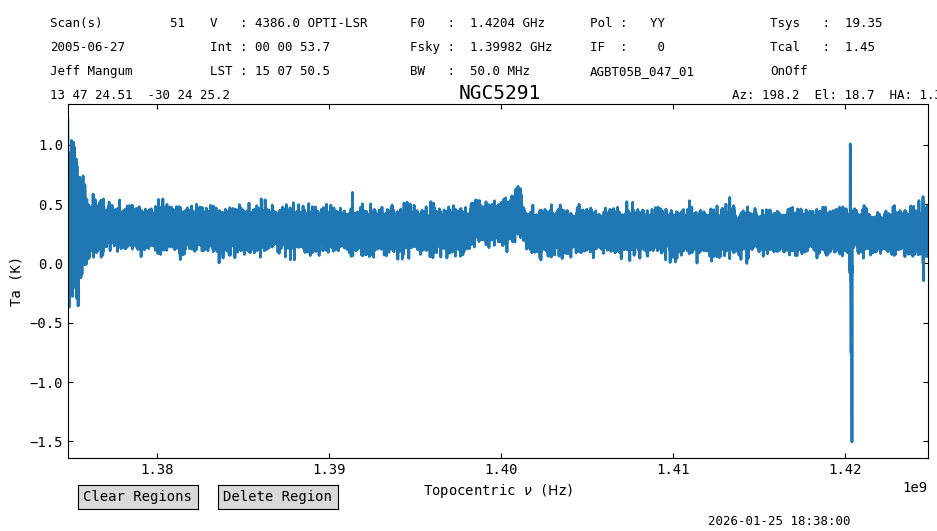

In [9]:
ta.plot()

Change the spectral axis units to km/s and the y-axis to mK, while also showing the spectra between 3600 and 5300 km/s, with the y-axis range between 0 and 1000 mK. Notice a small amount of "continuum" is left, most likely due to the varying sky in this **OnOff** positionswitch observation. We will need to perform a baseline subtraction later on in the notebook.

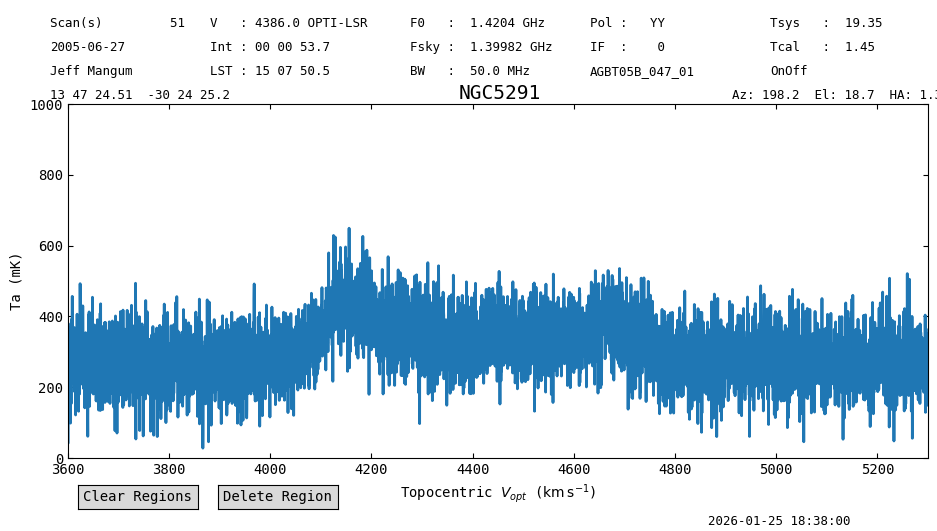

In [10]:
ta.plot(xaxis_unit="km/s", yaxis_unit="mK", ymin=0, ymax=1000, xmin=3600, xmax=5300)

Switch to channels as the spectral axis unit. 

Notice we are also returning a plotter object (`plt1`) so we can save it later with as baseline fit.

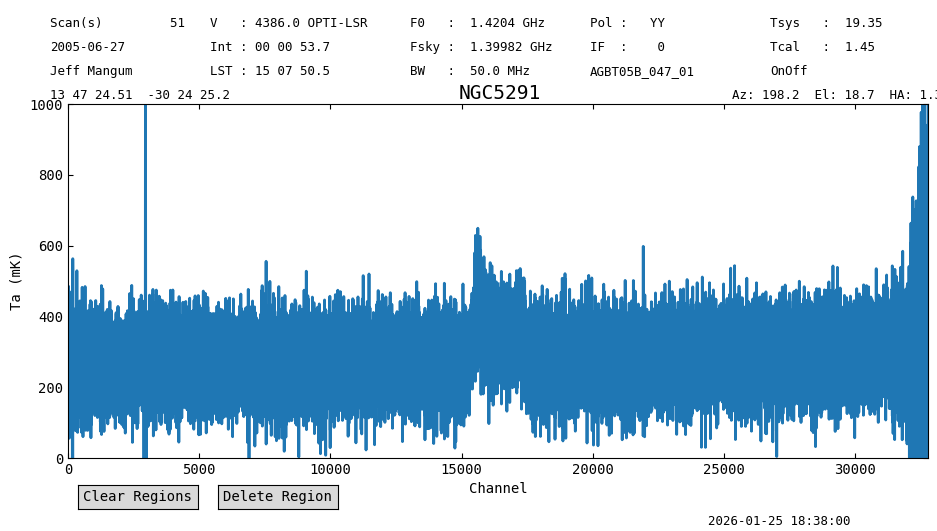

In [11]:
plt1 = ta.plot(xaxis_unit="chan", ymin=0, ymax=1000, yaxis_unit="mK")

#### Baseline Subtraction
The following code cells show how to subtract a polynomial baseline from the data. This example uses an 2nd order polynomial, and excludes the regions between 3800 and 5000 km/s, where a line is detected. The use of `remove=True` will remove the best fit baseline model from the spectrum, but by default the baseline is not subtracted. This has the nice side-effect that plotting the spectrum will also show the fitted baseline. (caveat: only the last plot before the baseline fit).

For a polynomial model one may need to normalize the frequency axis in channel space using `normalize=True`, to prevent poorly conditioned fits, but this will not allow you to undo the fit.

In [12]:
kms = u.km/u.s
ta.baseline(model="poly", degree=2, exclude=[3800*kms,5000*kms]) 
#  saving the plot will also show the baseline fit
plt1.savefig(output_dir / "plt1.png")


18:38:01.173 I EXCLUDING [Spectral Region, 1 sub-regions:
  (1397103816.4779327 Hz, 1402626103.134255 Hz) 
]


Notice that in interactive mode you would see the fitted baseline in the spectrum plot before. But in normal notebook mode, the 
figure needs to be saved explicitly. Re-executing the cell will overplot new baseline fits.

Now remove the baseline for sure. Again, this is not the default.

In [13]:
ta.baseline(model="poly", degree=2, exclude=[3800*kms,5000*kms], remove=True)

18:38:01.513 I EXCLUDING [Spectral Region, 1 sub-regions:
  (1397103816.4779327 Hz, 1402626103.134255 Hz) 
]


As an aside, exluding the obvious signal for NGC5291, will however include the edges, and the galactic emission around 0 km/s.  It would be better to use the `include=` keyword and give a list of two intervals, for example 500 to 3800 and 5000 to 9000 km/s.  We leave this as an exersize for the reader. You should find a difference of about 7 mK between the two solutions.

When we plot the spectrum again, it has been baseline subtracted.

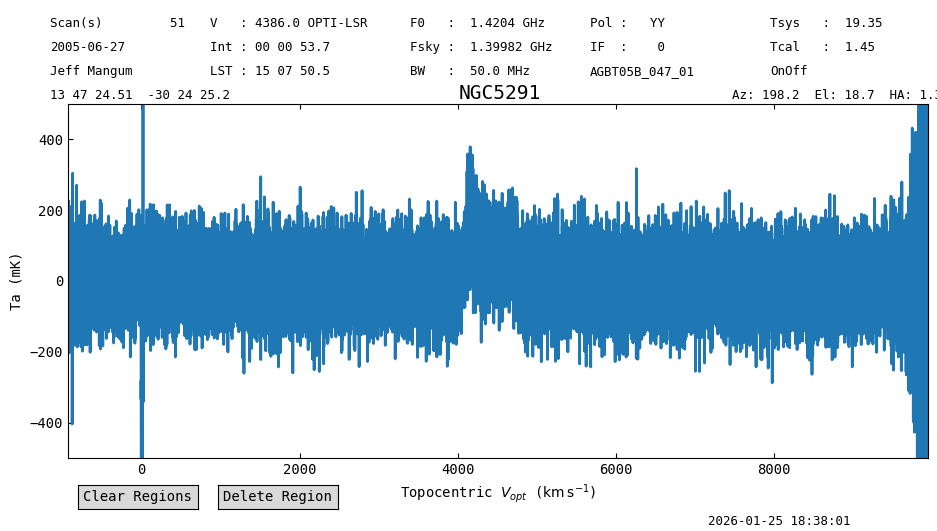

In [14]:
plt2 = ta.plot(xaxis_unit="km/s", yaxis_unit="mK", ymin=-500, ymax=500)

We can inspect the best fit baseline coefficients.

In [15]:
print(ta.baseline_model)

<QuantityModel Polynomial1D(2, c0=0.27098986, c1=0.02448574, c2=0.01186811, domain=(1424816838.1210938, 1374818364.0)), input_units=Hz, return_units=K>


And save the figure, now without a baseline fit of course.

In [16]:
plt2.savefig(output_dir / "baselined_removed.png")

If for some reason you are not happy, use the `ta.undo_baseline()` function and start with a new baseline fit. In dysh you can only fit one baseline per spectrum.

#### Using Selection

The following code shows how to calibrate scan 51 using selection. At this time selection does not know about signal and reference scan pairs, so the selection must include both scans, otherwise the calibration will fail.

In [17]:
sdfits.select(scan=[51,52])
sdfits.selection.show()

 ID    TAG      SCAN  # SELECTED
--- --------- ------- ----------
  0 82827a908 [51,52]         88


In [18]:
sb = sdfits.getps(plnum=0, ifnum=0, fdnum=0)

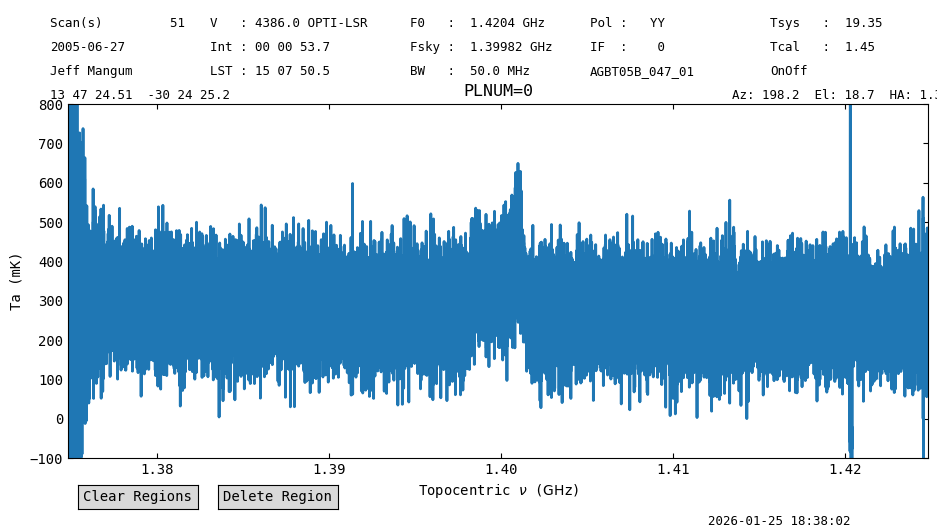

In [19]:
ta2 = sb.timeaverage(weights='tsys')
ta2.plot(xaxis_unit="GHz", ymin=-100, ymax=800, yaxis_unit="mK", title="PLNUM=0")

We can calibrate the other polarization, with the scan numbers already selected.

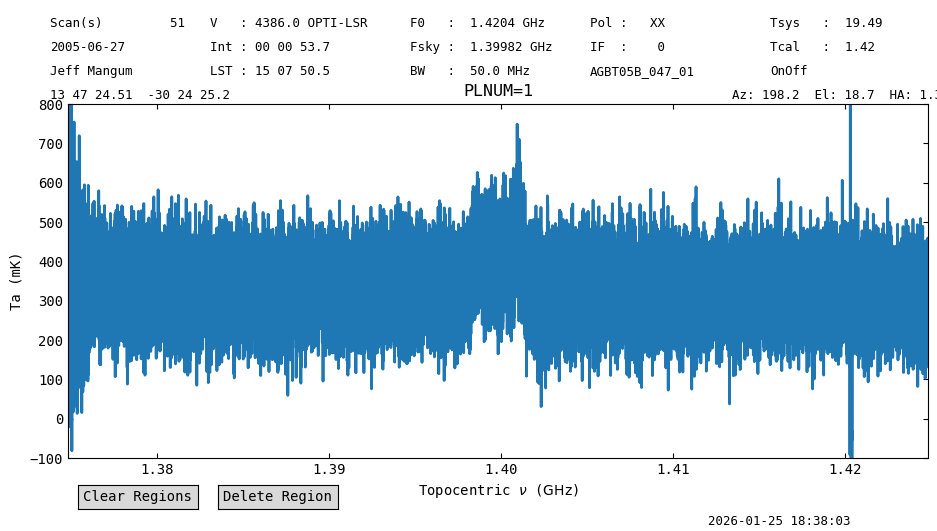

In [20]:
sb = sdfits.getps(plnum=1, fdnum=0, ifnum=0)
ta3 = sb.timeaverage(weights='tsys')
ta3.plot(xaxis_unit="GHz", ymin=-100, ymax=800, yaxis_unit="mK", title="PLNUM=1")

#### Polarization Average
Average the polarizations and plot the result.

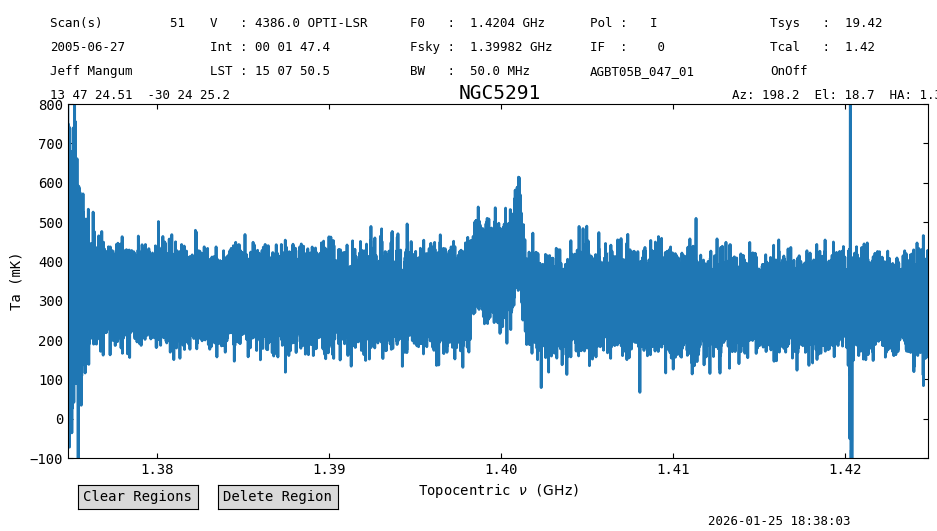

In [21]:
avg = ta2.average(ta3)
avg.plot(ymin=-100, ymax=800, yaxis_unit="mK", xaxis_unit="GHz")

### All Scans

Now we leverage the power of `dysh` to calibrate and time average all of the scans in the data.

We start by clearing the selection, so all of the scans are available.

In [22]:
sdfits.selection.clear()

Then, make a `ScanBlock` for spectral window 0, polarization 0, and feed 0. Time average the scans in the `ScanBlock` into a single `Spectrum` and then remove a baseline.

In [23]:
ps_scan_block_0 = sdfits.getps(ifnum=0, plnum=0, fdnum=0)
ps_ta_0 = ps_scan_block_0.timeaverage(weights='tsys')
ps_ta_0.baseline(model="poly", degree=2, exclude=[3800*kms,5000*kms], remove=True)

18:38:04.834 I EXCLUDING [Spectral Region, 1 sub-regions:
  (1397103816.4779327 Hz, 1402626103.134255 Hz) 
]


Now plot and compare with the result for a single scan.

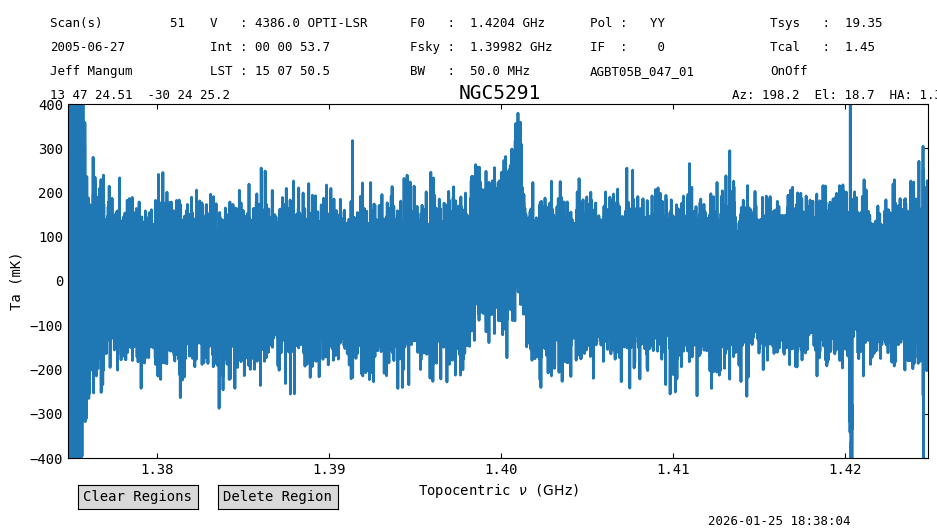

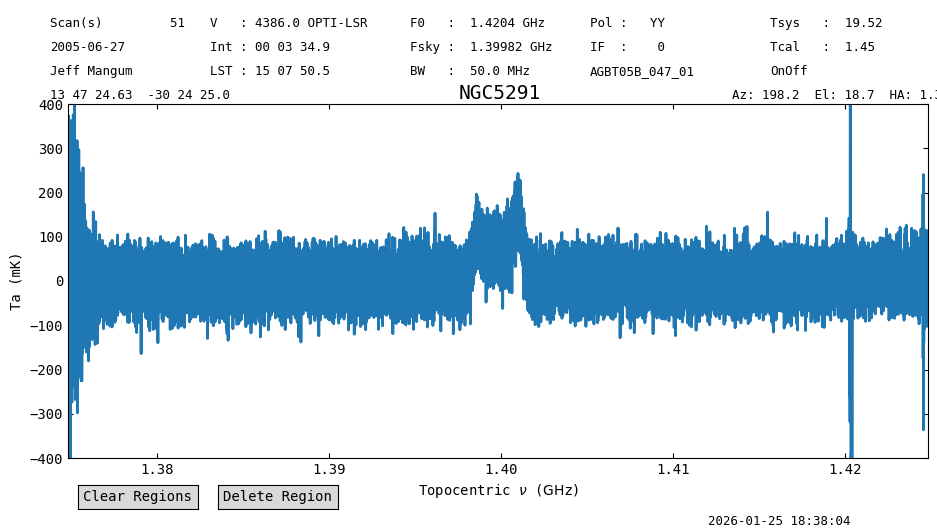

In [24]:
ta.plot(ymin=-400, ymax=400, yaxis_unit="mK", xaxis_unit="GHz")
ps_ta_0.plot(ymin=-400, ymax=400, yaxis_unit="mK", xaxis_unit="GHz")

The rms in the second Figure is almost half that of the first Figure. That is because there are four pairs of position switched scans in the data, so that results in a factor of $\sqrt{4}$ reduced noise when we average all the data.

## Final Stats

Finally, at the end we compute some statistics over a spectrum, merely as a checksum if the notebook is reproducable.


In [25]:
ps_ta_0.stats()  # rms 0.06010087 K

{'mean': <Quantity 0.0056479 K>,
 'median': <Quantity 0.00427112 K>,
 'rms': <Quantity 0.06010087 K>,
 'min': <Quantity -1.7342856 K>,
 'max': <Quantity 0.77205109 K>,
 'npt': 32768,
 'nan': 0}

In [26]:
# ps_ta_0[5000:15000].plot(xaxis_unit="chan").spectrum.radiometer()  # 1.0462122057623617